In [1]:
#Библиотеки
import numpy as np
import requests
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Первичное получение вакансий

In [116]:
#Получить вакансии по тексту
text=input('Что вы хотите найти в имени или описании вакансии? (через поисковый движок HH) \n')
target_text='https://api.hh.ru/vacancies?text='+text
r = requests.get(target_text).json() 
p=r['pages'] #Кол-во страниц выдачи
vac = []
#print('Ожидайте, поиск займет до '+str(p*2)+' секунд')
for i in tqdm_notebook(range(0, p)):
    vac.append(requests.get(target_text, params={'page': i, 'per_page':20}).json())
#Выгрузка вакансий
vac_row=[]
for i in range(0,p):
    l=len(vac[i]['items'])
    for j in range (0,l):
        vac_row.append(vac[i]['items'][j])
df=pd.DataFrame.from_dict(vac_row, orient='columns') 
#Очистка ЗП
df['salary_avg']=None
df['gross']=True
for i in range(0,len(df.salary)):
    if df.salary[i] is not None:
        df['gross'][i]=df['salary'][i]['gross']
        if df.salary[i]['to'] is not None and df.salary[i]['currency']=='RUR':
            df.salary_avg[i]=df.salary[i]['to']
        elif df.salary[i]['from'] is not None and df.salary[i]['currency']=='RUR':
            df.salary_avg[i]=df.salary[i]['from']
        elif df.salary[i]['to'] is not None and df.salary[i]['currency']=='USD':
            df.salary_avg[i]=df.salary[i]['to']*75
        elif df.salary[i]['from'] is not None and df.salary[i]['currency']=='USD':
            df.salary_avg[i]=df.salary[i]['from']*75
        elif df.salary[i]['to'] is not None and df.salary[i]['currency']=='EUR':
            df.salary_avg[i]=df.salary[i]['to']*90
        elif df.salary[i]['from'] is not None and df.salary[i]['currency']=='EUR':
            df.salary_avg[i]=df.salary[i]['from']*90    
        else:
            df.salary[i]=None
for d in range(0,len(df.salary)):
    if df['gross'][d]==False and df['salary_avg'][d] is not None:
        df.salary_avg[d]=df.salary_avg[d]/0.87
salary_clear=df.salary_avg.dropna()

#Город
for t in range (0, len(df.address)):
    if df.area[t] is not None:
        df.area[t]=df.area[t]['name']
#Работодатель
for k in range (0, len(df.employer)):
    if df.employer[k] is not None:
        df.employer[k]=df.employer[k]['name']
print('Найдено вакансий:',len(df.name),'\n')
#Убрать все где не указана зп
df=df.query('salary_avg>0')
print('Вакансий с указанной зарплатой:',len(df.name))

Что вы хотите найти в имени или описании вакансии? (через поисковый движок HH) 
монитор клинических исследований or CRA



Найдено вакансий: 70 

Вакансий с указанной зарплатой: 5


In [117]:
#Проверить названия вакансий
print('Всего уникальных названий вакансий:',df['name'].nunique())
print(df['name'].unique())

Всего уникальных названий вакансий: 5
['Специалист по клиническим исследованиям (монитор клинических исследований)'
 'Координатор клинических исследований'
 'Менеджер проектов клинических исследований'
 'Советник по клиническим исследованиям'
 'CRA/ Clinical research associate (oncology)']


# Фильтрация вакансий по названию или городу

In [118]:
#Обнуление фильтров
df_filtered=df
#Фильтрация "вакансия содержит х"
search_query_name=input("Введите ключевые слова, хотя бы одно из которых ОБЯЗАТЕЛЬНО ДОЛЖНО быть в имени вакансии без пробелов через разделитель | (например, Грузчик|Разнорабочий)\nЕсли дополнительная фильтрация не нужна - введите 0\n")
if not search_query_name=='0':
    df_filtered=df[df['name'].str.contains(search_query_name,case=False)]
#Повторно проверить названия вакансий
print('Всего уникальных названий вакансий после фильтрации:',df_filtered['name'].nunique())
print(df_filtered['name'].unique())

Введите ключевые слова, хотя бы одно из которых ОБЯЗАТЕЛЬНО ДОЛЖНО быть в имени вакансии без пробелов через разделитель | (например, Грузчик|Разнорабочий)
Если дополнительная фильтрация не нужна - введите 0
0
Всего уникальных названий вакансий после фильтрации: 5
['Специалист по клиническим исследованиям (монитор клинических исследований)'
 'Координатор клинических исследований'
 'Менеджер проектов клинических исследований'
 'Советник по клиническим исследованиям'
 'CRA/ Clinical research associate (oncology)']


In [119]:
#Фильтрация "вакансия НЕ содержит х"    
search_query_name_negative=input("\n\nВведите ключевые слова, которых НЕ ДОЛЖНО быть в имени вакансии без пробелов через разделитель | (например, Грузчик|Разнорабочий)\nЕсли дополнительная фильтрация не нужна - введите 0\n")
if not search_query_name_negative=='0':
    df_filtered=df_filtered[~df_filtered['name'].str.contains(search_query_name_negative,case=False)] 
#Повторно проверить названия вакансий
print('Всего уникальных названий вакансий после фильтрации:',df_filtered['name'].nunique())
print(df_filtered['name'].unique())



Введите ключевые слова, которых НЕ ДОЛЖНО быть в имени вакансии без пробелов через разделитель | (например, Грузчик|Разнорабочий)
Если дополнительная фильтрация не нужна - введите 0
0
Всего уникальных названий вакансий после фильтрации: 5
['Специалист по клиническим исследованиям (монитор клинических исследований)'
 'Координатор клинических исследований'
 'Менеджер проектов клинических исследований'
 'Советник по клиническим исследованиям'
 'CRA/ Clinical research associate (oncology)']


In [120]:
#Фильтрация "город содержит х"     
search_query_address=input("\nВведите города для поиска по адресу без пробелов через разделитель | (например, Москва|Санкт-Петербург)\nЕсли не нужно выбирать город - введите 0\n")
if not search_query_address=='0':
    df_filtered['area']=df_filtered['area'].fillna('-')
    df_filtered=df_filtered[df_filtered['area'].str.contains(search_query_address,case=False)]

#Печать результатов    
df_filtered=df_filtered.reset_index(drop=True)
print('\nНайдено вакансий после фильтрации:',len(df_filtered.name))
df_filtered=df_filtered.sort_values(by=['salary_avg'])
#Средняя зарплата
perc=str(df_filtered.salary_avg.quantile([.25,.5,.75,.9]))
print('\nПерцентили по заработной плате(руб.): \n')
print(perc.split('Name')[0])
df_filtered.to_excel(text+'.xlsx')
print('Данные выгружены в файл '+text+'.xlsx')  


Введите города для поиска по адресу без пробелов через разделитель | (например, Москва|Санкт-Петербург)
Если не нужно выбирать город - введите 0
0

Найдено вакансий после фильтрации: 5

Перцентили по заработной плате(руб.): 

0.25     91954
0.50    160000
0.75    200000
0.90    248000

Данные выгружены в файл монитор клинических исследований or CRA.xlsx


# Графики распределения заработных плат

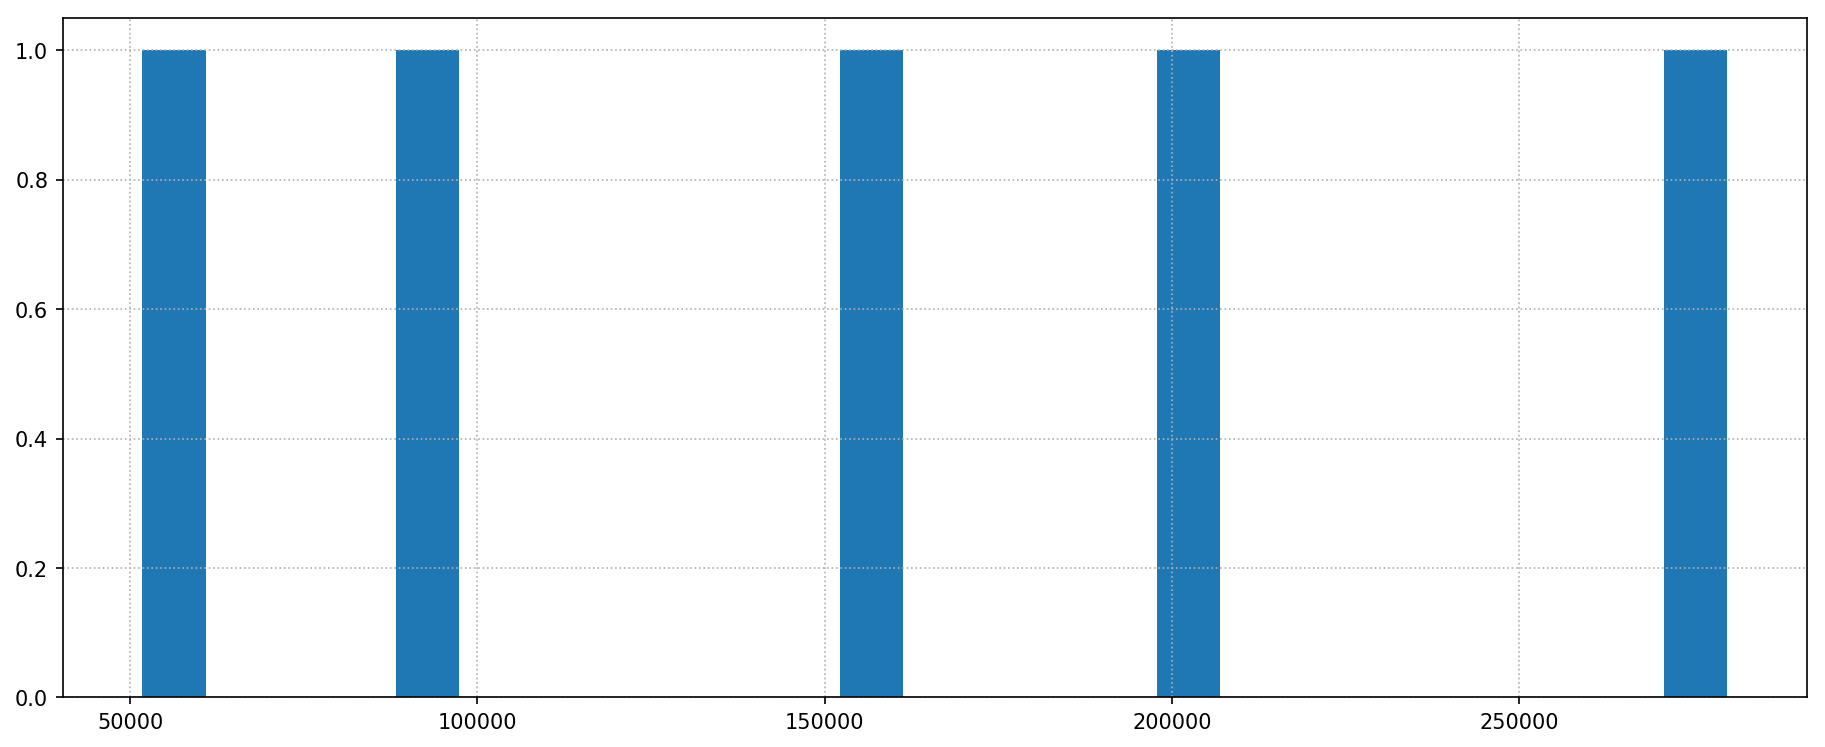

In [121]:
#Частотная диаграмма
salary_list=list(df_filtered.salary_avg.dropna())
plt.figure(figsize=(15, 6), dpi=150)
plt.hist(salary_list, bins= 25)
plt.grid(linestyle=':')
plt.show()

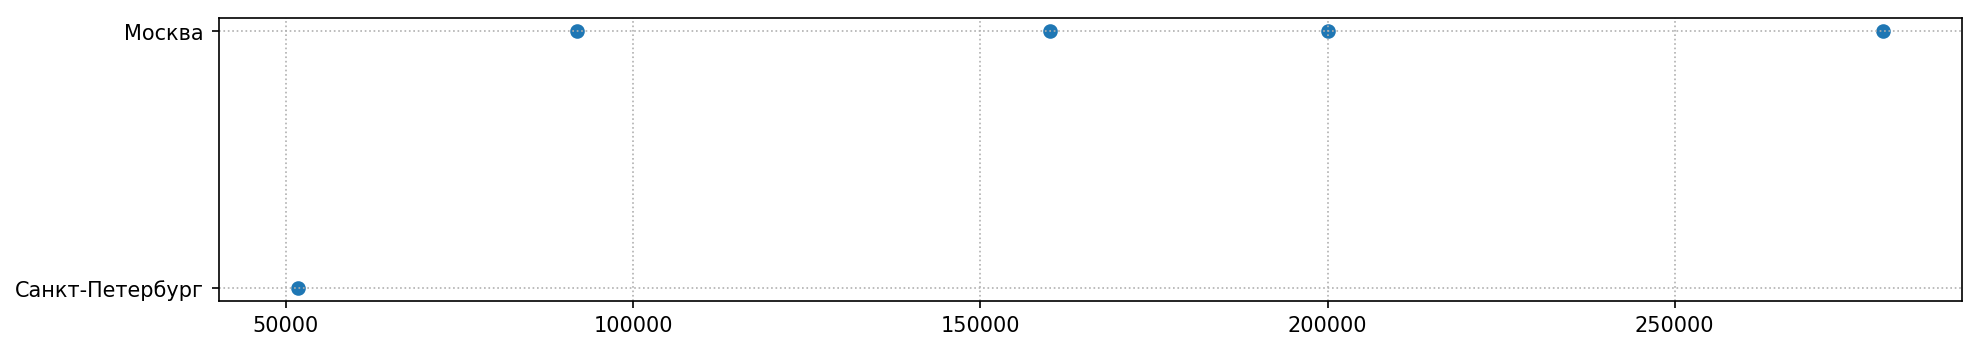

In [122]:
#Точечная диаграмма по городам
plt.figure(figsize=(15, 2+(df_filtered['area'].nunique()/4)), dpi=150)
df_filtered.query('salary_avg>0 and area==area')['salary_avg']
plt.scatter(df_filtered.query('salary_avg>0 and area==area')['salary_avg'],df_filtered.query('salary_avg>0 and area==area')['area'])
plt.grid(linestyle=':')
plt.show()

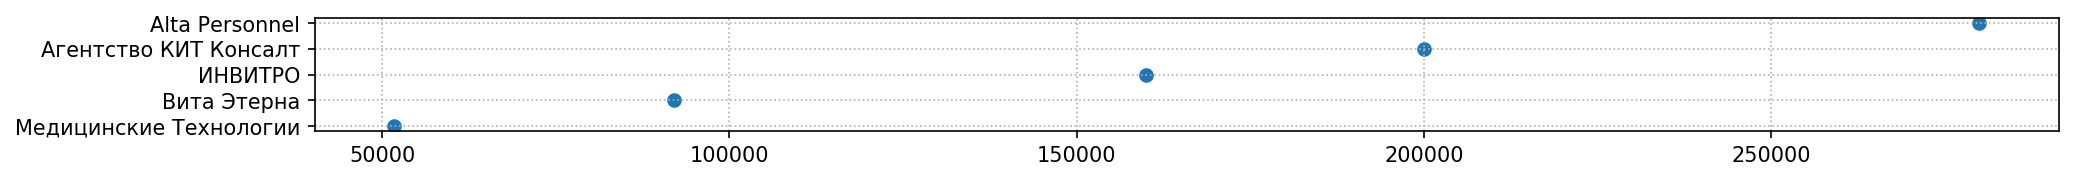

In [123]:
#Точечная диаграмма по работодателям
plt.figure(figsize=(15, len(df_filtered.query('salary_avg>0')['salary_avg'])/5), dpi=150)
df_filtered.query('salary_avg>0')['salary_avg']
df_filtered['address']=df_filtered['address'].fillna('Не указан')
plt.scatter(df_filtered.query('salary_avg>0')['salary_avg'],df_filtered.query('salary_avg>0')['employer'])
y_labels=df_filtered.query('salary_avg>0')['employer']
plt.yticks(y_labels)
plt.grid(linestyle=':')
plt.show()

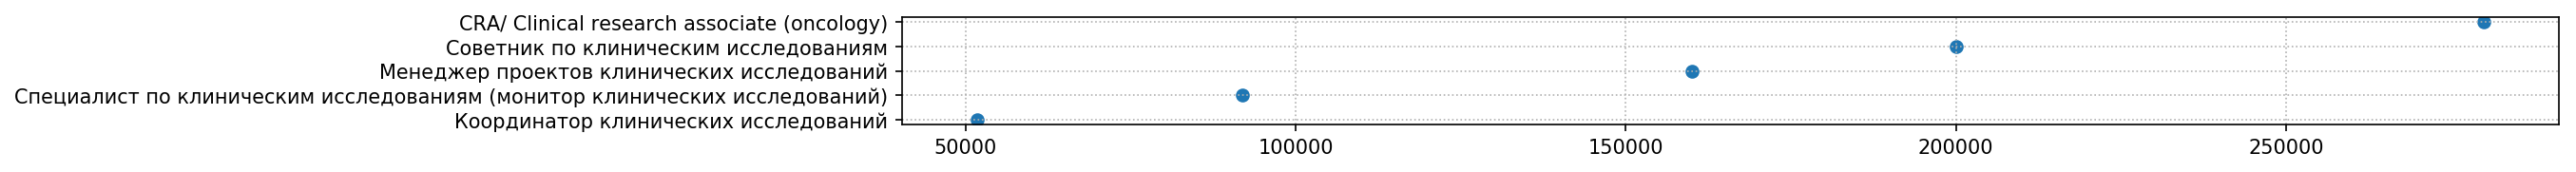

In [124]:
#Точечная диаграмма по названиям позиций
plt.figure(figsize=(15, len(df_filtered.query('salary_avg>0')['name'])/5), dpi=150)
plt.scatter(df_filtered.query('salary_avg>0')['salary_avg'],df_filtered.query('salary_avg>0')['name'])
y_labels=df_filtered.query('salary_avg>0')['name']
plt.yticks(y_labels)
plt.grid(linestyle=':')
plt.show()